# Hyperparameter Inference

In this notebook we use the simulation data from the simulation tutorial to reconstruct the input dark matter mass and signal fraction.

## Imports and general setup

Let's first import everything required for this script.

In [1]:
import os, sys, time, random
from scipy import interpolate, special, integrate

from gammabayes.hyper_inference import hyperparameter_likelihood
from gammabayes.priors import discrete_logprior
from gammabayes.dark_matter import SS_DM_dist
from gammabayes.likelihoods.irfs import single_loglikelihood
from gammabayes.priors import log_bkg_CCR_dist
from gammabayes.utils.event_axes import makelogjacob
from gammabayes.utils.config_utils import read_config_file, create_true_axes_from_config, create_recon_axes_from_config


import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

from multiprocessing import Pool, freeze_support
# Nothing stochastic in this notebook but just in case you want to add something to the script, 
#   this should be the same seed as the Simulation notebook
random.seed(1) 

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Script Parameter Setup

Just like with the simulation script we opt to use a yaml configuration file rather than specify 20+ parameters on every run. We'll extract these parameters from the config file and define a couple useful quantities, like the axes and the number of signal and background events.

In [2]:
startertimer = time.perf_counter()
print(startertimer)

config_inputs = read_config_file('example_run_script.yaml')

nsig                = int(round(config_inputs['signal_fraction']*config_inputs['Nevents']))
nbkg                = int(round((1-config_inputs['signal_fraction'])*config_inputs['Nevents']))

energy_axis_true, longitude_axis_true, latitude_axis_true = create_true_axes_from_config(config_inputs)
energy_axis, longitude_axis, latitude_axis = create_recon_axes_from_config(config_inputs)

true_mass = config_inputs['mass']


energymeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(energy_axis_true, longitude_axis_true, latitude_axis_true, indexing='ij')
lonmeshtrue, latmeshtrue = np.meshgrid(longitude_axis_true, latitude_axis_true, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitude_axis, latitude_axis, indexing='ij')
logjacobtrue = np.meshgrid(np.log(energy_axis_true), longitude_axis_true, latitude_axis_true, indexing='ij')[0]


config_inputs

735402.956681791
file path: example_run_script.yaml
0.1 100 100 0.2 -3.1 3.1 -3.0 3.0
0.1 100 50 0.4 -3.1 3.1 -3.0 3.0


{'identifier': 'example_config_run',
 'Nevents': 10000,
 'mass': 50.0,
 'signal_fraction': 0.5,
 'nbins_mass': 161,
 'nbins_sigfrac': 201,
 'dmdensity_profile': 'einasto',
 'numcores': 8,
 'runnumber': 1,
 'totalevents': 10000,
 'batch_job': 0,
 'true_energy_min': 0.1,
 'true_energy_max': 100,
 'true_energy_bins_per_decade': 100,
 'true_spatial_res': 0.2,
 'true_longitude_min': -3.1,
 'true_longitude_max': 3.1,
 'true_latitude_min': -3.0,
 'true_latitude_max': 3.0,
 'recon_energy_min': 0.1,
 'recon_energy_max': 100,
 'recon_energy_bins_per_decade': 50,
 'recon_spatial_res': 0.4,
 'recon_longitude_min': -3.1,
 'recon_longitude_max': 3.1,
 'recon_latitude_min': -3.0,
 'recon_latitude_max': 3.0}

The output of the cell should show all the relevant inputs from the config file.

# <h1><b>Simulation Result Loading

Let's first define the priors we'll need, it is recommended to use the same ones that went into the simulation otherwise you'll get wack results.

In [3]:

SS_DM_dist_instance= SS_DM_dist(longitude_axis_true, latitude_axis_true, density_profile=config_inputs['dmdensity_profile'])
logDMpriorfunc = SS_DM_dist_instance.func_setup()


DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=[config_inputs['mass']], 
                               hyperparameter_names=['mass'], 
                               logjacob=np.meshgrid(makelogjacob(energy_axis_true),longitude_axis_true, latitude_axis_true, indexing='ij')[0])
DM_prior

discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x155f13b00>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

In [4]:
from gammabayes.priors import log_bkg_CCR_dist
from gammabayes.priors.astro_sources import construct_fermi_gaggero_matrix, construct_hess_source_map
from gammabayes.utils import iterate_logspace_simps, logspace_simpson
from scipy import special, interpolate

nuisancemesh = np.meshgrid(energy_axis_true, longitude_axis_true, latitude_axis_true, indexing='ij')

from gammabayes.priors.astro_sources import construct_hess_source_map, construct_fermi_gaggero_matrix


astrophysicalbackground = construct_hess_source_map(energy_axis_true, longitude_axis_true, latitude_axis_true)+construct_fermi_gaggero_matrix(energy_axis_true, longitude_axis_true, latitude_axis_true)

log_misidentification_rate = np.squeeze(log_bkg_CCR_dist(*nuisancemesh))

unnormed_logbkgpriorvalues = np.logaddexp(log_misidentification_rate,np.log(astrophysicalbackground))

logbkgpriorvalues = unnormed_logbkgpriorvalues - iterate_logspace_simps(unnormed_logbkgpriorvalues, axes=[energy_axis_true, longitude_axis_true, latitude_axis_true])


logbkgfunc_tuple_input = interpolate.RegularGridInterpolator((energy_axis_true, longitude_axis_true, latitude_axis_true,), np.exp(logbkgpriorvalues))
logbkgfunc = lambda energy, longitude, latitude: np.log(logbkgfunc_tuple_input((energy, longitude, latitude)))


bkg_prior = discrete_logprior(logfunction=logbkgfunc, name='Background Prior',
                               axes=(energy_axis_true, longitude_axis_true, latitude_axis_true,), 
                               axes_names=['energy', 'lon', 'lat'], 
                               logjacob=np.meshgrid(makelogjacob(energy_axis_true),longitude_axis_true, latitude_axis_true, indexing='ij')[0])

bkg_prior

/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammapy/modeling/models/spatial.py:554: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


discrete log prior class
----------------------------
name = Background Prior
logfunction type is <function <lambda> at 0x156088d60>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) [None]

For the analysis, we also require the normalisation values of the IRFs to reduce memory loads. Different methods for computers with larger RAM capabilities is being developed that will hopefully cause an increase in speed from a factor of 100 to 1000.

In [5]:
from gammabayes.likelihoods.irfs.irf_normalisation_setup import irf_norm_setup
from gammabayes.likelihoods.irfs import log_psf, log_edisp
psfnormalisationvalues, edispnormalisationvalues = irf_norm_setup(energy_true_axis=energy_axis_true, energy_recon_axis=energy_axis, 
          longitudeaxistrue=longitude_axis_true, longitudeaxis=longitude_axis, latitudeaxistrue=latitude_axis_true, latitudeaxis=latitude_axis,
          psf=log_psf, edisp=log_edisp,
          save_results=False, outputresults=True)

Save directory is /Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/../package_data


Setting up psf normalisation:   0%|                     | 0/301 [00:00<?, ?it/s]

Setting up edisp normalisation: 100%|█████████| 301/301 [00:08<00:00, 34.89it/s]


Now we will load the actual measured or reconstructed values from the simulations and group them to a single set of 'measured' values like you would expect from CTA observations.

In [6]:
bkg_energy_measured, bkg_lon_measured, bkg_lat_measured = np.load(f'tutorial_data/recon_bkg_samples.npy')
signal_energy_measured, signal_lon_measured, signal_lat_measured = np.load(f'tutorial_data/recon_sig_samples.npy')

measured_energy = list(signal_energy_measured)+list(bkg_energy_measured)
measured_lon = list(signal_lon_measured)+list(bkg_lon_measured)
measured_lat = list(signal_lat_measured)+list(bkg_lat_measured)
len(measured_lat)

10000

Now we can start the actual analysis.

# <h1><b>Analysis

## Marginalisation

To get a discrete posterior in mass we need some discrete values of mass to test our data with. In the below cell we have 'zoomed in' to the region we know the posterior will and not waste time on points of zero probability to reduce computation time for this tutorial.

In [7]:


logmasswindowwidth      = 3/np.sqrt(config_inputs['signal_fraction']*config_inputs['totalevents'])

logmasslowerbound       = np.log10(config_inputs['mass'])-logmasswindowwidth
logmassupperbound       = np.log10(config_inputs['mass'])+logmasswindowwidth


# Do not bother setting the mass below the energy range as no events would be detected and you get nans
if logmasslowerbound < np.log10(energy_axis_true)[0]:
    logmasslowerbound   = np.log10(energy_axis_true)[0]

# You can set the mass above 100 TeV (logE=2) but you would be extrapolating
if logmassupperbound>2:
    logmassupperbound   =2


# The mass values we will test
massrange               = np.logspace(logmasslowerbound, logmassupperbound, config_inputs['nbins_mass']) 

From here we will start using the `hyperparameter_likelihood` class which currently handles most of the hyperparameter inference we will do. It takes in similar inputs to the prior classes with of course the addition of the priors to be evaluated and the likelihood function to be used. The `likelihood` input should take a function that takes in the the axes and dependent axes and outputs the log-likelihood for those values. 

The class additionally takes in the normalisation for this likelihood as it is hard to maintain normalisation with interpolation which is generally what is done with the CTA IRFs/likelihood as they are generated stochastically and thus have no analytical form.

In [8]:
from gammabayes.hyper_inference import discrete_hyperparameter_likelihood

hyperparameter_likelihood_instance = discrete_hyperparameter_likelihood(
    priors                  = (DM_prior, bkg_prior,), 
    likelihood              = single_loglikelihood, 
    dependent_axes          = (energy_axis_true,  longitude_axis_true, latitude_axis_true), 
    hyperparameter_axes     = [[massrange], [None]], 
    numcores                = config_inputs['numcores'], 
    likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

Once we've instantiated the class we can then use the `nuisance_log_marginalisation` class method to return the log likelihood values after marginalising over the nuisance/true values.

In [9]:
measured_energy = [float(measured_energy_val) for measured_energy_val in measured_energy]

log_margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(
            axisvals        = (measured_energy, measured_lon, measured_lat),  )

Setting up prior matrices: 100%|██████████| 2/2 [02:32<00:00, 76.44s/it] 
Performing parallelized direct event marginalisation: 100%|██████████| 10000/10000 [00:00<00:00, 1313552.35it/s]
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/gammapy_wrappers.py:115: RuntimeWarning: divide by zero encountered in log
  output  = np.log(psffull.evaluate(energy_true=true_energy*u.TeV,
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/likelihoods/irfs/gammapy_wrappers.py:119: RuntimeWarning: divide by zero encountered in log
  output  += np.log(edispfull.evaluate(energy_true=true_energy*u.TeV,
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/integration.py:140: RuntimeWarning: divide by zero encountered in log
  result= np.logaddexp(result, np.log(addon)-max_val)
/Users/lpin0002/anaconda3/envs/testofwest/lib/python3.12/site-packages/gammabayes/utils/integration.py:138: RuntimeW

Let's put the result into a numpy array and extract the marginalisation values for the background and the signal respectively.

In [10]:
log_margresultsarray = np.array(log_margresults)
log_sigmargresults = np.squeeze(np.vstack(log_margresultsarray[:,0])).T
log_bkgmargresults = np.squeeze(np.vstack(log_margresultsarray[:,1]))
log_sigmargresults.shape

(161, 10000)

Now we have the log signal marginalisation results we can look at the log mass probability densities for each event. It's not needed but it looks nice!

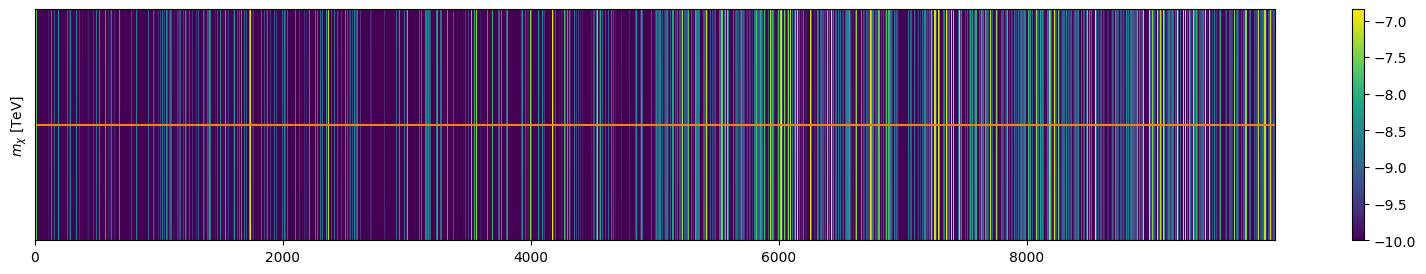

In [11]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(config_inputs['Nevents'])), massrange, indexing='ij'), 
               log_sigmargresults.T-special.logsumexp(log_sigmargresults, axis=1), 
               cmap='viridis', vmin=-10)
plt.ylabel(r'$m_\chi$ [TeV]')
plt.yscale('symlog')
plt.axhline(config_inputs['mass'], c='tab:orange')
plt.colorbar()
plt.show()

## Calculating posterior

Similar to what we did with the logmass 'window' we can do the same with the signal fraction. Uncomment the relevant code to make a zoomed in window of values to test.

In [12]:
sigfrac_lowerbound = 0
sigfrac_upperbound = 1


# sigfracwindowwidth      = 6/np.sqrt(config_inputs['totalevents'])

# sigfrac_lowerbound       = config_inputs['signal_fraction']-sigfracwindowwidth
# sigfrac_upperbound       = config_inputs['signal_fraction']+sigfracwindowwidth


# if sigfrac_lowerbound<0:
#     sigfrac_lowerbound = 0
# if sigfrac_upperbound>1:
#     sigfrac_upperbound = 1


sigfrac_range            = np.linspace(sigfrac_lowerbound, sigfrac_upperbound, config_inputs['nbins_sigfrac']) 

We can then use the `create_mixture_log_hyperparameter_likelihood` class method to calculate the hyperparameter likelihood, not posterior as we haven't applied the priors, although we choose them to be relatively uninformative for the mass and signal fraction so the total result won't change. Essentially we put in the `mixture_axes`, should be one for each components and the sum of the values for each component should add to 1, and then the log marginalisation results from the previous step. if they are alreadu stored within the class instance than the method will use the defaults.


This should take only a few seconds at most for up to ~10000 events.

In [13]:
log_hyperlikelihood = hyperparameter_likelihood_instance.create_discrete_mixture_log_hyper_likelihood(
    mixture_axes=(sigfrac_range, ), log_margresults=log_margresultsarray)

log_hyperlikelihood = np.squeeze(log_hyperlikelihood - special.logsumexp(log_hyperlikelihood))

endertimer = time.perf_counter()
print(endertimer-startertimer)

4357.375932084047


# <h1><b>Plotting

Now let's have a look at the result with the function `logdensity_matrix_plot`.

In [14]:
log_hyperlikelihood.shape

(201, 161)

(201,) (201,)
(161,) (161,)


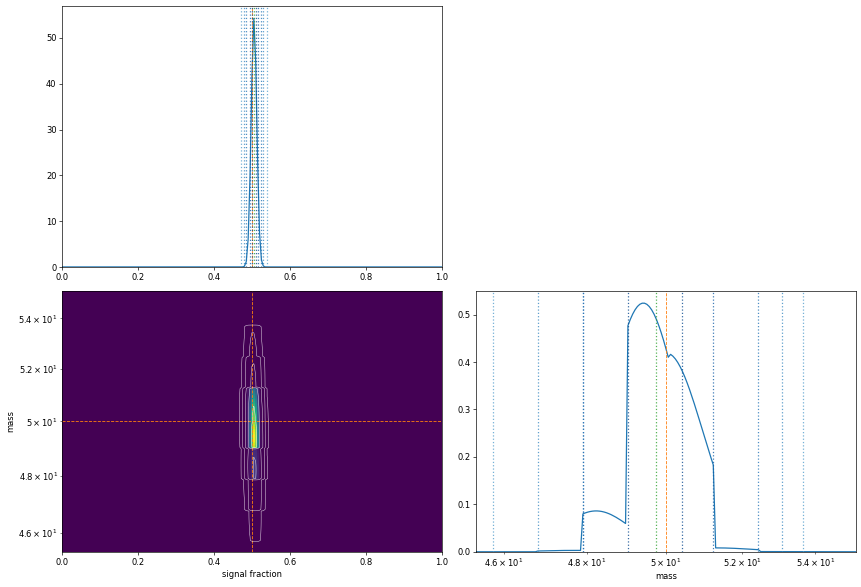

In [15]:
from gammabayes.utils.plotting import logdensity_matrix_plot

fig,ax = logdensity_matrix_plot(axes=[sigfrac_range, massrange], log_dist_matrix=np.squeeze(log_hyperlikelihood), 
                            truevals=[config_inputs['signal_fraction'], config_inputs['mass']], sigmalines_1d=True,  
                            contours2d = True, axis_names=['signal fraction', 'mass'],
                            plot_density=True,
                            single_dim_yscales='linear', figsize=(14,10), dpi=60)
ax[1,0].set_yscale('log')
ax[1,1].set_xscale('log')
plt.show()

In [16]:
help(logdensity_matrix_plot)

Help on function logdensity_matrix_plot in module gammabayes.utils.plotting:

logdensity_matrix_plot(axes, log_dist_matrix, truevals=None, sigmalines_1d=True, sigmas=range(0, 6), cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x156019730>, contours2d=False, levels=array([0.99999627, 0.99966454, 0.988891  , 0.86466472, 0.39346934]), axis_names=None, suptitle='', suptitlesize=12, plot_density=False, norm=None, single_dim_yscales='symlog', single_dim_ylabel='', vmin=None, vmax=None, **kwargs)



The standard result should have the cross between the vertical and horizontal lines fall within the first, second or third white ellipse. 

If the intersection falls outside the third white ellipse then you've probably either encountered a statistical miracle or something has gone wrong.